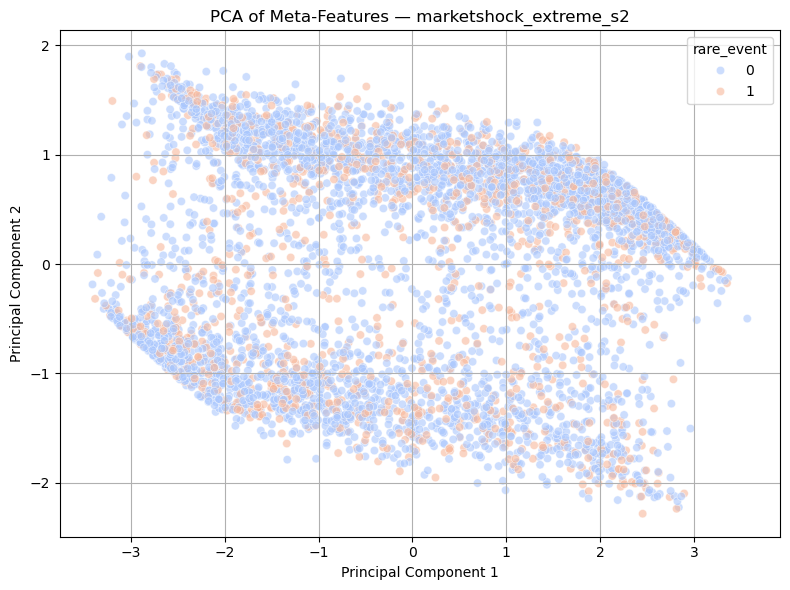


💡 Top 5 features contributing to PC1:
retail_sales           0.629988
credit_spread          0.614127
yield_curve_slope      0.448917
fx_volatility          0.435640
manufacturing_index    0.247031
Name: PC1, dtype: float64

💡 Top 5 features contributing to PC2:
fx_volatility           0.561861
long_term_bond_yield    0.541496
housing_starts          0.454573
retail_sales            0.325848
market_liquidity        0.262631
Name: PC2, dtype: float64


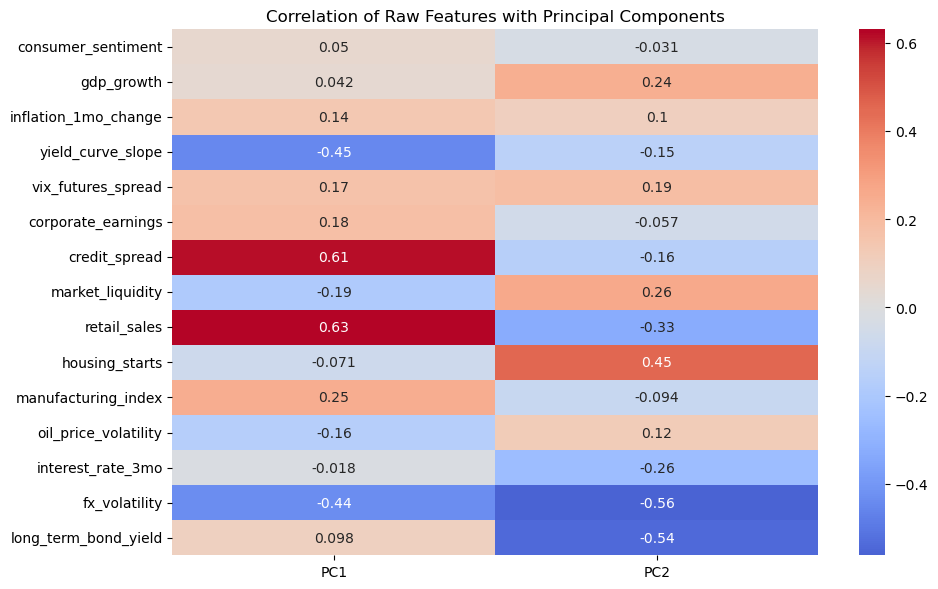

In [7]:
# 🔍 Rare Event Unblinding & PCA Insight Notebook

import os
import glob
import joblib
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# 📁 Paths
data_folder = "market_shock_synthetic_datasets"
model_folder = "champion_stacks"
base_model_folder = "champion_packages"

# 📦 Load All Datasets
datasets = {os.path.basename(p).replace(".csv", ""): pd.read_csv(p)
            for p in glob.glob(os.path.join(data_folder, "*.csv"))}

# 🏷️ Simulated economic labels for features
feature_labels = {
    "feature_0": "consumer_sentiment",
    "feature_1": "gdp_growth",
    "feature_2": "inflation_1mo_change",
    "feature_3": "yield_curve_slope",
    "feature_4": "vix_futures_spread",
    "feature_5": "corporate_earnings",
    "feature_6": "credit_spread",
    "feature_7": "market_liquidity",
    "feature_8": "retail_sales",
    "feature_9": "housing_starts",
    "feature_10": "manufacturing_index",
    "feature_11": "oil_price_volatility",
    "feature_12": "interest_rate_3mo",
    "feature_13": "fx_volatility",
    "feature_14": "long_term_bond_yield"
}

# 📦 Load Base Models (used for meta-feature creation)
base_model_paths = [p for p in glob.glob(os.path.join(base_model_folder, "*.pkl")) if "_meta" not in p]
base_models = [joblib.load(p) for p in base_model_paths]

# 📊 Analyze One Dataset (you can loop or choose dynamically)
selected_name = list(datasets.keys())[0]  # e.g., 'marketshock_medium_s1'
df = datasets[selected_name]
X_raw = df.drop("rare_event", axis=1)
X_named = X_raw.rename(columns=feature_labels)
y = df["rare_event"]

# 🧠 Rebuild Meta-features
meta_features = []
for model in base_models:
    try:
        meta_features.append(model.predict_proba(X_raw)[:, 1])
    except AttributeError:
        meta_features.append(model.decision_function(X_raw))

X_meta = np.vstack(meta_features).T

# 🎛️ Standardize & PCA
data_scaled = StandardScaler().fit_transform(X_meta)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_scaled)

# 🧩 Build Final DataFrame for Visualization
pca_df = pd.DataFrame(pca_components, columns=["PC1", "PC2"])
pca_df["rare_event"] = y.values

# 🎨 Plot PCA
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="rare_event", palette="coolwarm", alpha=0.6)
plt.title(f"PCA of Meta-Features — {selected_name}")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📌 Unblinding: Project PCA components back to raw features
raw_scaled = StandardScaler().fit_transform(X_named)
projected = pd.DataFrame(raw_scaled, columns=X_named.columns)
projected["PC1"] = pca_components[:, 0]
projected["PC2"] = pca_components[:, 1]

# 🔍 Correlation of raw features with principal components
correlations = projected.corr().loc[X_named.columns, ["PC1", "PC2"]]

# 💡 Show top contributing features per PC
for pc in ["PC1", "PC2"]:
    top_features = correlations[pc].abs().sort_values(ascending=False).head(5)
    print(f"\n💡 Top 5 features contributing to {pc}:")
    print(top_features)

# 📊 Optional: Heatmap of all correlations
plt.figure(figsize=(10,6))
sns.heatmap(correlations, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation of Raw Features with Principal Components")
plt.tight_layout()
plt.show()
